**This notebook implements the [grey wolf optimiser](https://www.sciencedirect.com/science/article/pii/S0965997813001853) to select the best features for a cyberattack classifier.** Each feature subset tested is used to train a classifier on the [Canadian Institute of Cybersecurity's IoT-2023 dataset](https://www.kaggle.com/datasets/madhavmalhotra/unb-cic-iot-dataset). 


**The current algorithm works, though it's slowed down a lot by the error function** (which trains a two-layer neural network from scratch and evaluates its accuracy) for every feature subset tried. This proved to be difficult to optimise with a NVIDIA K80 GPU due to low GPU utilisation rates (20%). The likely bottleneck is transferring data onto the GPU, so more work is needed.  


# Load Libraries

In [1]:
# Data handling and automatic backprop
import torch as t
import pandas as pd

# Misc
from typing import Callable
import matplotlib.pyplot as plt

# Data handling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Create Grey Wolf Optimiser 

I made this class independent of the fitness function that it was called with, so it's easy to customise (and hopefully further optimise) the error function in the future. 

In [2]:
class GreyWolfOptimiser:
    """ Creates an optimiser for feature selection in a large dataset """

    def __init__(self, error_function : Callable[[t.Tensor], float], 
                 population_size : int, num_dimensions : int, num_iterations : int, 
                 mean : float = 1.0, c_err : float = 1.0, c_size : float = 1.0, a : float = 2.0) -> None:
        
        # This is the bottleneck. It evaluates how good a particular subset of features is. 
        # Function specs: input = t.Tensor (dim: num_dimensions). return = float (0-1).
        self.err = error_function
        
        # number of wolves (min 3, raise for larger feature spaces)
        self.pop = population_size
        
        # number of features to select from 
        self.dims = num_dimensions 
        
        # how many times to test solutions (raise for larger feature spaces)  
        self.iters = num_iterations
        
        # generalised mean exponent (1.0 = arithmetic mean, ~0.0+ = geometric)
        self.mean = mean
        
        # how much to prioritise error function minimisation vs. size of feature set
        self.c_err = c_err
        self.c_size = c_size
        
        # how much wolves explore (increase for more exploration)
        self.a = a

    def init_wolves(self) -> t.Tensor:
        """ Returns a population of wolves with random 1/0s per feature to include/exclude """
        return t.randint(2, (self.pop, self.dims))
        
    def fitness(self, wolves : t.Tensor) -> t.Tensor:
        """ Returns error of each wolf in the population (lower is better) """
        return t.Tensor([
            self.c_err * self.err(w) + self.c_size * (t.sum(w) / self.dims) for w in wolves
            ])

    def compare_wolves(self, wolves : t.Tensor) -> list:
        """ Returns [positions, fitness, followers] of alpha, beta, delta wolves """
        f = self.fitness(wolves)
        sort_f = t.argsort(f)        
        sorted_wolves = wolves[sort_f]
        return sorted_wolves[:3], f[sort_f][:3], sorted_wolves[3:]
    
    def next_positions(self, wolves : t.Tensor, top : t.Tensor, 
                       curr_iter : int) -> t.Tensor:
        """ 
        For each wolf, find possible next positions given alpha, beta, delta 
        
        Parameters
        ----------------
        wolves (type: t.Tensor, dim: (pop_size, feature_dims)): 
            positions of all wolves
        top (type: t.Tensor, dim: (3, feature_dims)): 
            positions of alpha, beta, delta wolves
        curr_iter (type: int): 
            current iteration number

        Returns
        ----------------
        next_positions (type: np.ndarray, dim: (pop_size, 3, feature_dims)): 
            three possible next positions for each wolf given alpha, beta, delta
        """
        
        # Update current a vector
        a_curr = self.a * (1 - curr_iter / self.iters)
        # Generate random vectors
        r1 = t.rand((1, self.dims))
        r2 = t.rand((1, self.dims))

        # Compute alpha, beta, delta distances
        d_alpha = t.abs(2 * r1 * top[0:1, :] - wolves)
        d_alpha = top[0:1, :] - (2 * a_curr * r2 - a_curr) * d_alpha
        d_beta = t.abs(2 * r1 * top[1:2, :] - wolves)
        d_beta = top[1:2, :] - (2 * a_curr * r2 - a_curr) * d_beta
        d_delta = t.abs(2 * r1 * top[2:3, :] - wolves) 
        d_delta = top[2:3, :] - (2 * a_curr * r2 - a_curr) * d_delta
        
        # Compute next positions for followers 
        wolves = (d_alpha + d_beta + d_delta)**self.mean
        wolves = (wolves/3) ** (1 / self.mean)
        wolves = t.clamp(t.round(wolves), 0, 1)
        
        # Preserve existing top solutions
        return t.cat( (top, wolves) ) 
    
    def optimise(self) -> list:
        """ Returns the best wolf and error history after optimisation """

        wolves = self.init_wolves()
        err_history = []

        for i in range(self.iters):
            print(f'Iteration: {i}/{self.iters}')
            top, err, followers = self.compare_wolves(wolves)
            err_history.append(err[0])
            wolves = self.next_positions(followers, top, i)

        return self.compare_wolves(wolves)[0][0], err_history

# Load Data

Note: currently, I'm using 0.1% of the CIC-IoT-2023 dataset. Although I've preserved class balance when sampling this 0.1%, the sample of data I have doesn't represent the overall dataset. It's possible for the algorithm to use higher percentages (like 5-10%), though computational time of the custom error function is the current bottleneck.

In [3]:
# Setup scaler to reuse
df = pd.read_csv('/kaggle/input/creating-a-smaller-dataset-for-ciciot2023/0.001percent_8classes.csv')
scaler = StandardScaler()

# Drop categorical protocol_type (not useful, see: https://www.kaggle.com/code/madhavmalhotra/feature-exploration-on-ciciot2023/)
df = df.drop(['protocol_type'], axis=1)
df_labels = df['label']
df = df.drop(['label'], axis=1)

# Scale numerical features
scaler.fit(df)
df[:] = scaler.transform(df[:])

In [4]:
# Make data types more efficient
for col in df.columns:
    df[col] = df[col].astype('float32')
    
df_labels = df_labels.astype('category')
df_labels.value_counts()

label
DDoS        33871
DoS          8054
Mirai        2650
Benign       1093
Spoofing      545
Recon         302
Name: count, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46515 entries, 0 to 46514
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flow_duration    46515 non-null  float32
 1   header_length    46515 non-null  float32
 2   duration         46515 non-null  float32
 3   rate             46515 non-null  float32
 4   srate            46515 non-null  float32
 5   drate            46515 non-null  float32
 6   fin_flag_number  46515 non-null  float32
 7   syn_flag_number  46515 non-null  float32
 8   rst_flag_number  46515 non-null  float32
 9   psh_flag_number  46515 non-null  float32
 10  ack_flag_number  46515 non-null  float32
 11  ece_flag_number  46515 non-null  float32
 12  cwr_flag_number  46515 non-null  float32
 13  ack_count        46515 non-null  float32
 14  syn_count        46515 non-null  float32
 15  fin_count        46515 non-null  float32
 16  urg_count        46515 non-null  float32
 17  rst_count   

In [6]:
train, test, train_labels, test_labels = \
    train_test_split(df, df_labels, stratify=df_labels, test_size=0.2)

del df
del df_labels

# Create Fitness Evaluation

This is the most computationally expensive part of the grey wolf optimiser. So I'll use a simple logistic regression classifier and [only 5% of all data points](https://www.kaggle.com/code/madhavmalhotra/creating-a-smaller-dataset-for-ciciot2023). 

In [7]:
def get_data(wolves : t.Tensor) -> list:
    """ Returns train and test tensors """
    
    # Get tensors
    feats = wolves.bool().tolist()
    
    X_tr = t.from_numpy( train.loc[:, feats].to_numpy() )
    y_tr = t.from_numpy(train_labels.cat.codes.to_numpy().copy()).long()
    
    X_te = t.from_numpy( test.loc[:, feats].to_numpy()  )
    y_te = t.from_numpy(test_labels.cat.codes.to_numpy().copy()).long()
    
    return X_tr, y_tr, X_te, y_te

In [8]:
WARNING_GLOBAL_COST = []
WARNING_GLOBAL_GRAD = []

def error_func(wolves : t.Tensor) -> float:
    """ Trains LR classifier on feature subset. Returns change in loss """
    
    print(".", end="")
    
    # Init data, model, loss
    X_tr,y_tr, X_te,y_te = get_data(wolves)
    model = t.nn.Sequential(t.nn.Linear(X_te.shape[1], len(train_labels.cat.categories)))
    
    loss = t.nn.CrossEntropyLoss()
    start = -loss(model(X_te), y_te)
    cost_history = []
    grad_history = []
    
    # Hardcoding values since this func must be custom (ie. it won't be reused)
    lr = 0.67
    
    for iter in range(25):
        # Forward and backward pass
        pred = model(X_tr)
        cost = loss(pred,y_tr)
        
        cost_history.append(float(cost))
        cost.backward()
        
        # Update parameters
        with t.no_grad():
            for p in model.parameters():
                p -= lr * p.grad
                grad_history.append(t.norm(lr * p.grad))
            
            model.zero_grad()
    
    # Save visualisation data and return change in performance
    WARNING_GLOBAL_COST.append(cost_history)
    WARNING_GLOBAL_GRAD.append(grad_history)
    return start + loss(model(X_te), y_te)

# Run GWO

In [9]:
population_size = 50                     
num_dimensions = len(train.columns)
max_iters = 10                            
c_err = 10                            # Minimise error, not size
c_size = 0

gwo = GreyWolfOptimiser(error_func, population_size, num_dimensions, max_iters, c_err=c_err, c_size=c_size)

In [10]:
WARNING_GLOBAL_COST = []
WARNING_GLOBAL_GRAD = []
top, err = gwo.optimise()

Iteration: 0/10
..................................................Iteration: 1/10
..................................................Iteration: 2/10
..................................................Iteration: 3/10
..................................................Iteration: 4/10
..................................................Iteration: 5/10
..................................................Iteration: 6/10
..................................................Iteration: 7/10
..................................................Iteration: 8/10
..................................................Iteration: 9/10
....................................................................................................

In [11]:
# Show the best features selected in the end
feats = top.bool().tolist()
train.loc[:, feats].head()

,header_length,duration,rst_flag_number,dns,tot_sum,avg,std,iat,magnitue,weight
26344,-0.138598,-0.165953,-0.316366,-0.008031,-0.294379,-0.305890,-0.199067,-0.004376,-0.357649,0.001912
40290,-0.166881,-0.165953,-0.316366,-0.008031,-0.326019,-0.338722,-0.199067,0.017604,-0.453998,0.001912
42566,-0.110815,0.754494,-0.316366,-0.008031,-0.335887,-0.226652,-0.068371,-4.866498,-0.158713,-4.872141
26011,-0.166767,-0.165953,-0.316366,-0.008031,-0.278560,-0.289474,-0.199067,0.007742,-0.312373,0.001912
20396,-0.166767,-0.165953,3.160895,-0.008031,-0.278560,-0.289474,-0.199067,0.009554,-0.312373,0.001912


In [12]:
train.loc[:, feats].info()

<class 'pandas.core.frame.DataFrame'>
Index: 37212 entries, 26344 to 26993
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   header_length    37212 non-null  float32
 1   duration         37212 non-null  float32
 2   rst_flag_number  37212 non-null  float32
 3   dns              37212 non-null  float32
 4   tot_sum          37212 non-null  float32
 5   avg              37212 non-null  float32
 6   std              37212 non-null  float32
 7   iat              37212 non-null  float32
 8   magnitue         37212 non-null  float32
 9   weight           37212 non-null  float32
dtypes: float32(10)
memory usage: 1.7 MB


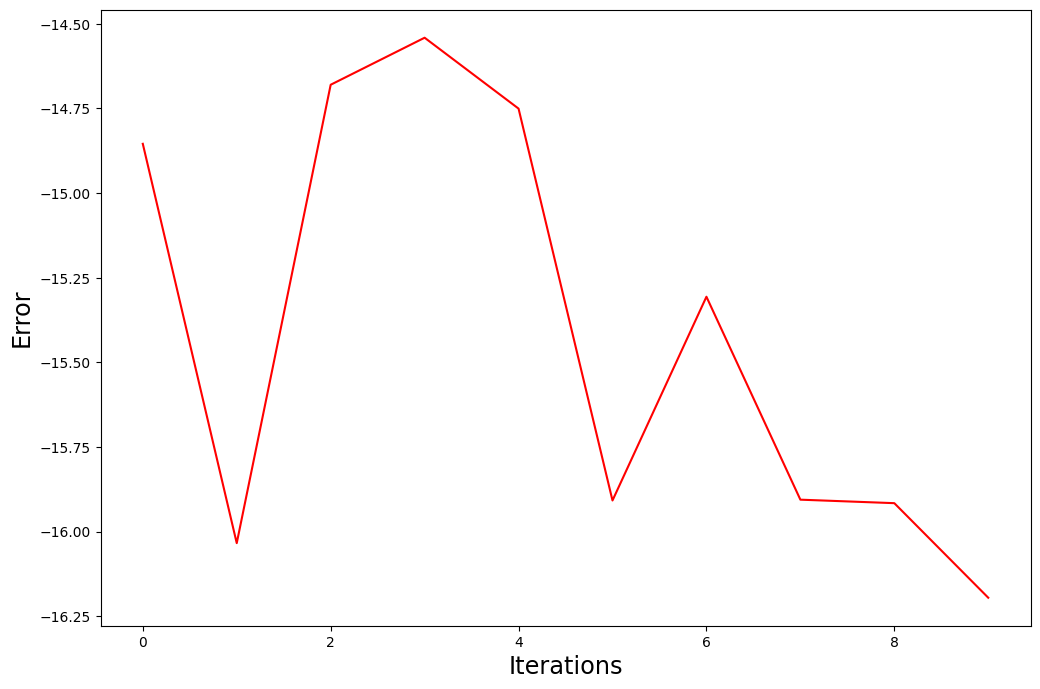

In [13]:
# This is how the best feature selection changed over time
plt.figure(figsize=(12,8))
plt.xlabel("Iterations", size='xx-large')
plt.ylabel("Error", size='xx-large')

plt.plot(range(len(err)), err, color='red')
plt.show()

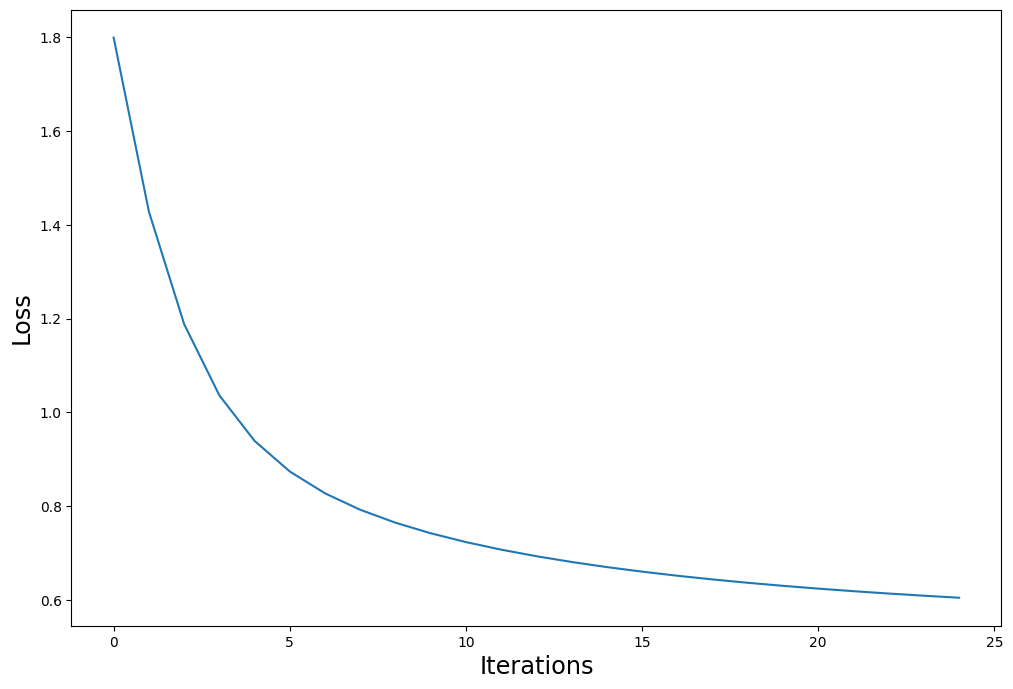

In [14]:
plt.figure(figsize=(12,8))
plt.xlabel("Iterations", size='xx-large')
plt.ylabel("Loss", size='xx-large')
plt.plot(range(len(WARNING_GLOBAL_COST[3])), WARNING_GLOBAL_COST[3]) 

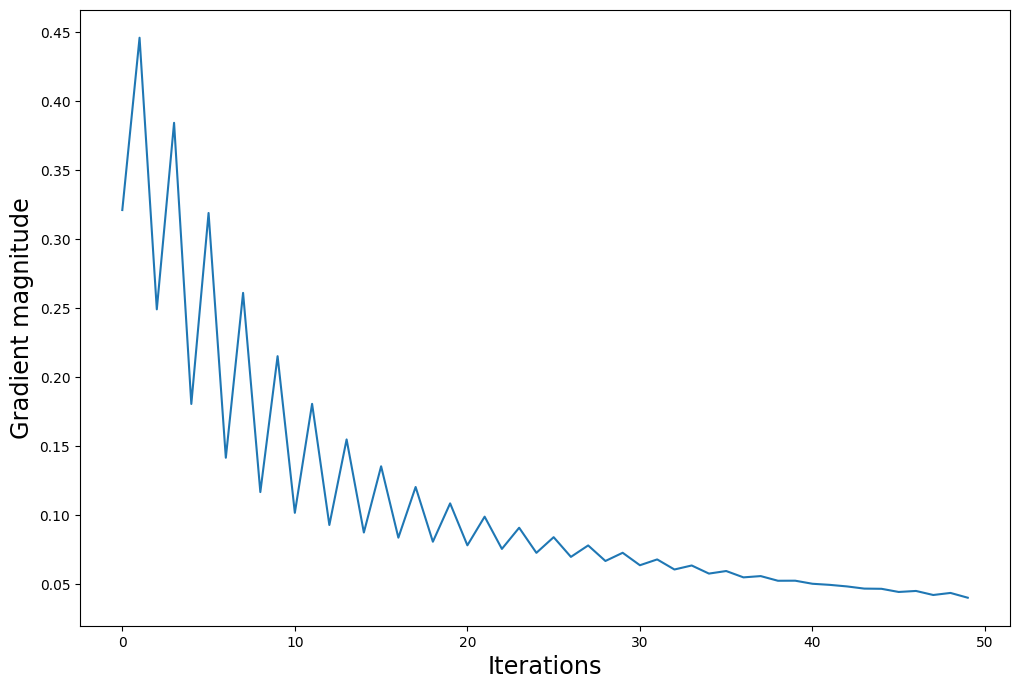

In [15]:
plt.figure(figsize=(12,8))
plt.xlabel("Iterations", size='xx-large')
plt.ylabel("Gradient magnitude", size='xx-large')
plt.plot(range(len(WARNING_GLOBAL_GRAD[0])), WARNING_GLOBAL_GRAD[0]) 